In [1]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [20]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from utils import load_data

In [9]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


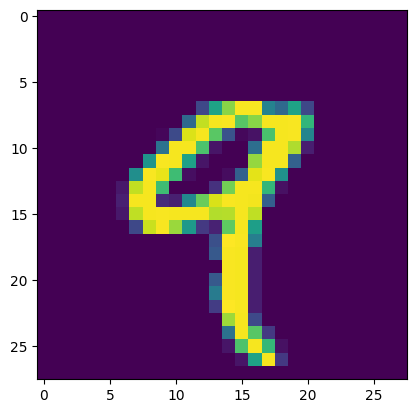

In [5]:
plt.imshow(train_input[4].view((28,28)))

In [15]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [7]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [8]:
def sigma(x):
    return torch.tanh(x)

def dsigma(x):
    return 1 - torch.pow(torch.tanh(x), 2)

In [9]:
def loss(v, t):
    return torch.sum(torch.pow(t - v, 2))

def dloss(v, t):
    return 2 * (v - t)

In [10]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dloss(v,t)

tensor([[ 2.3527, -0.7847, -1.4954, -0.4929,  1.5305, -3.0965],
        [ 3.5871, -1.6806,  0.7551,  2.2729, -0.3817, -1.7495],
        [ 1.3005, -0.9118, -7.4731, -1.1744,  1.7405, -0.9367]])

In [11]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [12]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [13]:
torch.manual_seed(1337)
w1 = torch.randn((784, 50))
b1 = torch.randn((50,))
w2 = torch.randn((50, 10))
b2 = torch.randn((10,))
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [14]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1 @ w1 + b1
h1 = sigma(z1)
z2 = h1 @ w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(43.2825, grad_fn=<SumBackward0>))

In [15]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=43.282527923583984


In [16]:
b2.grad.shape

torch.Size([10])

In [17]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2, y1) * dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2) * dh2
cmp('z2',dz2, z2)
dw2 = h1.T @ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2 @ w2.T
cmp('h1',dh1, h1)
dz1 = dsigma(z1) * dh1
cmp('z1', dz1, z1)
dw1 = x1.T @ dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: False | approximate: True  | maxdiff: 1.6298145055770874e-09
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
z1              | exact: False | approximate: True  | maxdiff: 4.423782229423523e-09
w1              | exact: False | approximate: True  | maxdiff: 5.960464477539063e-08
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [19]:
l = loss(h2, y1)
l.item()

43.282527923583984

##### Now that we've checked our gradients are correct, we can implement the network


\begin{aligned}
z_1 &= x \, w_1 + b_1, \quad &z_2 &= h_1 \, w_2 + b_2,\\[1mm]
h_1 &= \tanh(z_1), \quad &h_2 &= \tanh(z_2).
\end{aligned}


\begin{aligned}
L = \|h_2 - y_1\|^2,
\end{aligned}

so that

\begin{aligned}
\frac{\partial L}{\partial h_2} = 2\,(h_2 - y_1).
\end{aligned}

**For layer 2:**

- **Output gradient:**
  \begin{aligned}
  dh_2 = 2\,(h_2 - y_1).
  \end{aligned}

- **Backpropagation through tanh:**
  \begin{aligned}
  dz_2 = \Bigl( 1 - \tanh(z_2)^2 \Bigr) \odot dh_2.
  \end{aligned}

- **Gradients for layer 2 parameters:**
  \begin{aligned}
  dw_2 = h_1^\top\,dz_2, \quad db_2 = \sum dz_2.
  \end{aligned}


In [20]:
def forward(w1, b1, w2, b2, x):
    z1 = x @ w1 + b1 
    h1 = torch.tanh(z1)
    z2 = h1 @ w2 + b2 
    h2 = torch.tanh(z2) 
    return z1, h1, z2, h2


In [2]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = 2 * (h2 - y1) * dl
    dz2 = (1 - torch.tanh(z2)**2) * dh2
    dw2 = h1.T @ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2 @ w2.T
    dz1 = (1 - torch.tanh(z1)**2) * dh1
    dw1 = x1.T @ dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [3]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr * dw1
        b1 += -lr * db1
        w2 += -lr * dw2
        b2 += -lr * db2
    return w1, b1, w2, b2

In [4]:
def init():
    """ init a network """
    d_in, d_hidden, d_out = 784, 50, 10 

    w1 = torch.randn(d_in, d_hidden, dtype=torch.float32)
    b1 = torch.zeros(1, d_hidden, dtype=torch.float32)
    w2 = torch.randn(d_hidden, d_out, dtype=torch.float32)
    b2 = torch.zeros(1, d_out, dtype=torch.float32)
    return w1, b1, w2, b2

In [34]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [35]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

        
    

In [36]:
lossi = train(w1, b1, w2, b2)


step = 0, loss = 9504.736328125
step = 100, loss = 8104.51904296875
step = 200, loss = 7691.15625
step = 300, loss = 7346.40234375
step = 400, loss = 7139.935546875
step = 500, loss = 7003.6728515625
step = 600, loss = 6897.9560546875
step = 700, loss = 6767.8232421875
step = 800, loss = 6645.294921875
step = 900, loss = 6520.8115234375
step = 1000, loss = 6400.4716796875
step = 1100, loss = 6251.13818359375
step = 1200, loss = 6066.435546875
step = 1300, loss = 5738.021484375
step = 1400, loss = 5373.2373046875
step = 1500, loss = 4900.6435546875
step = 1600, loss = 4774.84375
step = 1700, loss = 4454.84375
step = 1800, loss = 4028.462646484375
step = 1900, loss = 3699.22216796875
step = 2000, loss = 3455.9130859375
step = 2100, loss = 2922.5048828125
step = 2200, loss = 2314.978515625
step = 2300, loss = 1827.2293701171875
step = 2400, loss = 1675.8970947265625
step = 2500, loss = 1355.322998046875
step = 2600, loss = 1157.1231689453125
step = 2700, loss = 1058.230224609375
step = 28

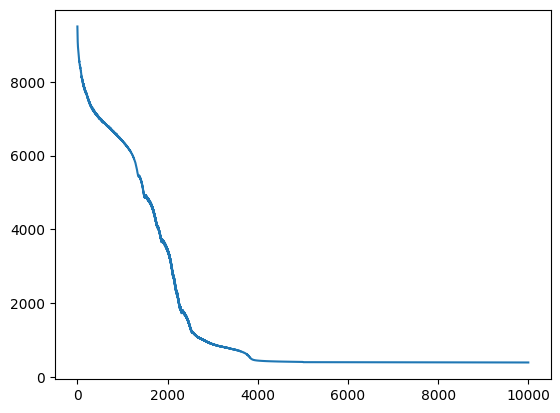

In [37]:
plt.plot(lossi)

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [38]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [39]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [40]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 9828.4453125
step = 100, loss = 8500.265625
step = 200, loss = 8066.193359375
step = 300, loss = 7751.35693359375
step = 400, loss = 7523.30859375
step = 500, loss = 7368.03076171875
step = 600, loss = 7210.2314453125
step = 700, loss = 7055.98291015625
step = 800, loss = 6895.6259765625
step = 900, loss = 6773.4970703125
step = 1000, loss = 6647.2919921875
step = 1100, loss = 6489.837890625
step = 1200, loss = 6298.23828125
step = 1300, loss = 5985.755859375
step = 1400, loss = 5388.27734375
step = 1500, loss = 5225.85546875
step = 1600, loss = 5064.68896484375
step = 1700, loss = 4855.19970703125
step = 1800, loss = 4596.484375
step = 1900, loss = 4109.81591796875
step = 2000, loss = 3103.76416015625
step = 2100, loss = 3023.46875
step = 2200, loss = 2930.156005859375
step = 2300, loss = 2845.63037109375
step = 2400, loss = 2764.825927734375
step = 2500, loss = 2680.46240234375
step = 2600, loss = 2613.88623046875
step = 2700, loss = 2551.559326171875
step = 2800, lo

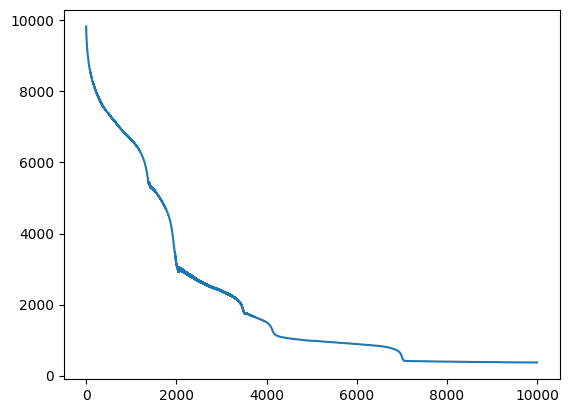

In [41]:
plt.plot(lossi)

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [5]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [12]:
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

In [28]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(784, 50),
            nn.Tanh(),
            nn.Linear(50, 10),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [29]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')




step =      0	loss=0.13933	accuracy (train, test): 0.17300	0.21900
step =   1000	loss=0.00112	accuracy (train, test): 1.00000	0.84300
step =   2000	loss=0.00026	accuracy (train, test): 1.00000	0.84000
step =   3000	loss=0.00010	accuracy (train, test): 1.00000	0.83500
step =   4000	loss=0.00022	accuracy (train, test): 1.00000	0.83300
step =   5000	loss=0.00008	accuracy (train, test): 1.00000	0.82900
step =   6000	loss=0.00008	accuracy (train, test): 1.00000	0.83200
step =   7000	loss=0.00004	accuracy (train, test): 1.00000	0.83100
step =   8000	loss=0.00005	accuracy (train, test): 1.00000	0.82900
step =   9000	loss=0.00003	accuracy (train, test): 1.00000	0.82700


##### Exercise: try to improve accuracy!

In [48]:
class MLP_with_Dropout(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((
            nn.Linear(784, 50),
            nn.Tanh(),
            nn.Dropout(p=0.1), 
            nn.Linear(50, 10),
            nn.Tanh()
        ))

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters]

model_with_dropout = MLP_with_Dropout()
model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
loss_fn = nn.MSELoss()

In [49]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')


step =      0	loss=0.18017	accuracy (train, test): 0.06800	0.06000
step =   1000	loss=0.04498	accuracy (train, test): 0.85400	0.72300
step =   2000	loss=0.03711	accuracy (train, test): 0.90200	0.75700
step =   3000	loss=0.03377	accuracy (train, test): 0.92800	0.78200
step =   4000	loss=0.03200	accuracy (train, test): 0.93000	0.79300
step =   5000	loss=0.03103	accuracy (train, test): 0.93600	0.79900
step =   6000	loss=0.03049	accuracy (train, test): 0.93700	0.80000
step =   7000	loss=0.03019	accuracy (train, test): 0.93700	0.80200
step =   8000	loss=0.03004	accuracy (train, test): 0.93700	0.80400
step =   9000	loss=0.02996	accuracy (train, test): 0.93800	0.80400
